In [10]:
%matplotlib inline
import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
import igraph as ig

In [4]:
from scipy.optimize import fsolve, fmin, root
import sympy as sy
from mis_utils import *

# Simulation-driven comparison with IG 

In [5]:
num_iter = 10;
nN = 20;
xs = np.linspace(0, 1, 2000); #lazy xs

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_gauss_pred = {}
new_gauss_pred_boost = {}
dens = {}

In [9]:
import time
from datetime import datetime

import igraph as igg
new_k_min = 2
new_k_max = 15
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
precision = 10
new_ps = np.linspace(new_pmin,new_pmax,precision);

from scipy.stats import norm

for l,p in tqdm(enumerate(new_ps)):
    print(l, '/', precision, ':', len(new_ps), 'started:', str(datetime.now()))
    new_gauss_pred[p] = []
    new_res_ig[p] = []
    new_av_k_ig[p] = [];
    new_n_ig_dict[p] = []
    dens[p] = []
    new_gauss_pred_boost[p] = []
    for it in range(num_iter):
        g = igt.create_ER_bipartite_graph(nN,p) # create ER bipartite graph
        lg = igt.line_graph(g) # create line graph
        ig = igt.interference_graph(lg) # create interference graph
        ig_degs = list(dict(ig.degree()).values())
        new_av_k_ig[p].append(np.mean(ig_degs)); # computed z
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[p].append(new_n_ig); # compute number of tasks M
        nx.write_gml(ig,'test_gt.gml'); #horrible trick
        g_igraph = igg.load('test_gt.gml') 
        new_res_ig[p].append( g_igraph.alpha() )  # empirical/real MIS size
        
        # direct prediction
        mu = new_av_k_ig[p][-1]
        sigma = np.std(ig_degs)
        p_stars_gauss = minimize_gauss_pstar(xs, mu, sigma, 2); #prediction based on gaussian IG degree distribution
        new_gauss_pred[p].append(rho_gauss(p_stars_gauss, mu , sigma, 2)); #prediction based on gaussian IG degree distribution
        dens[p].append(nx.density(ig));
        
        #indirect prediction on predicted degrees
        g_degs = dict(nx.degree(g));
        tt = [g.degree()[i] for i in range(nN)]
        ss = [g.degree()[i] for i in range(nN,2*nN)]

        boosted_degree_corrected = []
        for edge in g.edges():
            boosted_degree_corrected.append(igt.wedge_closure_boosted_degree_corrected(g_degs[edge[0]], g_degs[edge[1]], np.array(ss), np.array(tt)));
        
        mu = np.mean(boosted_degree_corrected)
        sigma = np.std(boosted_degree_corrected)
        p_stars_gauss = minimize_gauss_pstar(xs, mu, sigma, 2); #prediction based on gaussian IG degree distribution
        new_gauss_pred_boost[p].append(rho_gauss(p_stars_gauss, mu , sigma, 2)); #prediction based on gaussian IG degree distribution

<ipython-input-9-5db6b478024c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l,p in tqdm_notebook(enumerate(new_ps)):


0 / 10 : 10 started: 2020-11-23 12:19:00.019308
1 / 10 : 10 started: 2020-11-23 12:19:00.799040
2 / 10 : 10 started: 2020-11-23 12:19:02.658298
3 / 10 : 10 started: 2020-11-23 12:19:08.105322
4 / 10 : 10 started: 2020-11-23 12:19:18.866870
5 / 10 : 10 started: 2020-11-23 12:19:32.622548
6 / 10 : 10 started: 2020-11-23 12:19:48.086649
7 / 10 : 10 started: 2020-11-23 12:20:06.604138
8 / 10 : 10 started: 2020-11-23 12:20:25.411904
9 / 10 : 10 started: 2020-11-23 12:20:44.894754



In [11]:
cmap = plt.cm.hot
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [12]:
av_dens = [np.mean(dens[x]) for x in new_ps]

No handles with labels found to put in legend.


(0.0, 0.7)

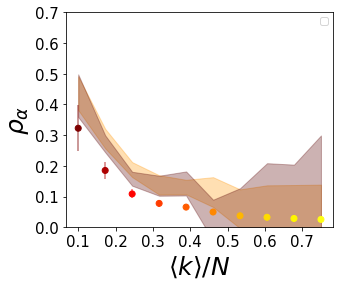

In [13]:
fs = 25
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)

data = new_gauss_pred
yy = np.array(list(map(lambda x: np.mean(data[x]), sorted(data.keys()))));
std_yy = np.array(list(map(lambda x: np.std(data[x]), sorted(data.keys()))));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150))

data = new_gauss_pred_boost
yy = np.array(list(map(lambda x: np.mean(data[x]), sorted(data.keys()))));
std_yy = np.array(list(map(lambda x: np.std(data[x]), sorted(data.keys()))));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(30))


data = new_res_ig
yy = list(map(lambda x: np.mean(np.array(data[x])/np.array(list(map(float,new_n_ig_dict[x])))), sorted(data.keys())));
std_yy = list(map(lambda x: np.std(np.array(data[x])/np.array(list(map(float,new_n_ig_dict[x])))), sorted(data.keys())));
plt.errorbar(new_ps,yy, std_yy, ms=0,alpha=0.4, color=cmap(av_dens),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
plt.scatter(new_ps, yy, c=cmap(av_dens), vmin=0, vmax=1)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$\langle k \rangle/N$', fontsize=fs)
plt.box('off')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc=0)
plt.tight_layout()
plt.ylim(0,0.7)

In [14]:
pd.DataFrame(new_gauss_pred).to_csv('./figure_data/Fig_3c_gaussian_alpha_prediction_from_GT_data.csv')
pd.DataFrame(new_res_ig).to_csv('./figure_data/Fig_3c_gaussian_alpha_simulation_from_GT_data.csv')

In [15]:
fig2c = {'simulations': new_res_ig, 'predictions': new_gauss_pred}
import pickle as pk
pk.dump(fig2c, open('./figure_data/figure2c.pck', 'wb'))